# Unsupervised ML for fraud detection-Groupe 9

### Alann CHERAL, Yanis DACI, Clément HARDY, Manon CESAIRE, Sajeevan PUVIKARAN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap

from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
import sklearn

In [2]:
# Import data from csv
fraud = pd.read_csv("./creditcard.csv")

In [3]:
fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Drop the label and Time features
target = fraud.Class
fraud.drop(["Class", "Time"], 1, inplace=True)

We have dropped the Time feature as this feature **is not relevant** in our use case.

## Normalized data

In [5]:
from sklearn import preprocessing

We have done a MinMaxScaler normalization ($\frac{value - \min}{\max - \min}$) in order to get values into the interval \[0,1\].

In [6]:
fraud = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(fraud.values), columns=fraud.columns, index=fraud.index)

## Dimensionality Reduction

As a first approach, we will try to reduce dimensions and to plot data. The goal is to find if we can **separate data into 2 clusters**: **fraud** and **non-fraud** clusters.

### PCA

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(fraud)

In [8]:
def plot_PCA(data=fraud, y=target):
    result_PCA = PCA(n_components=2).fit_transform(data)
    
    col = ["blue", "red"]
    plt.figure()
    plt.scatter(result_PCA[(y==0),0], result_PCA[(y==0),1], color=col[0])
    plt.scatter(result_PCA[(y==1),0], result_PCA[(y==1),1], color=col[1])
    plt.show()

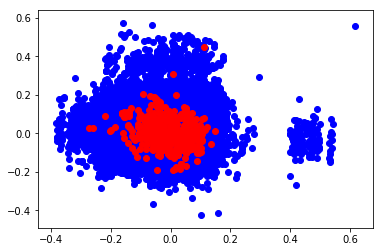

In [9]:
plot_PCA()

**Comment**: The data has been split into 2 clusters. However, the fraud has not been separated from the non-fraud data. We can remark that the fraud data are all grouped together in the first cluster.

Even if the method does not separate well, we will see that with the 2 other methods, it won't be better. We consider this plot as the reference for the clustering type methods.

<div class="alert alert-danger" role="alert">
  The following 2 methods take **much more time** to run than PCA method.
</div>

### T-SNE


In [10]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(fraud)

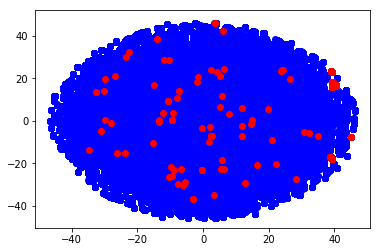

In [19]:
col = ["blue", "red"]
plt.figure()
plt.scatter(X_embedded[(target==0),0], X_embedded[(target==0),1], color=col[0])
plt.scatter(X_embedded[(target==1),0], X_embedded[(target==1),1], color=col[1])
plt.show()

### UMAP 

In [12]:
result = umap.UMAP().fit_transform(fraud)

C:\Users\Hard Med lenovo\AppData\Local\conda\conda\envs\python 3.6\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 104 separate connected components using meta-embedding (experimental)
  n_components
C:\Users\Hard Med lenovo\AppData\Local\conda\conda\envs\python 3.6\lib\site-packages\umap\spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


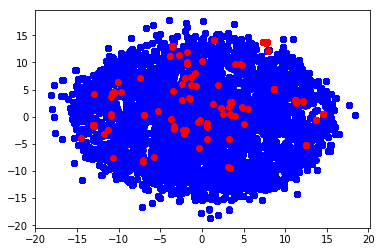

In [20]:
plt.figure()
plt.scatter(result[(target==0),0], result[(target==0),1], color=col[0])
plt.scatter(result[(target==1),0], result[(target==1),1], color=col[1])
plt.show()

**Comment:** Using **T-SNE and UMAP methods**, there is only a unique cluster. It gathers all data with fraud data all around the cluster.

## Clustering

In [10]:
def print_result_method(detected_outliers, name_method):
    '''
        Print some stats for a specific Clustering type Method.
        It returns the relevance of the method:
            - Find the real outliers from detected outliers.
            - Ability to separate real outliers from data (excluding false-positive). 
    '''
    print("The {} method give the following results:".format(name_method))
    print("\t Number of real outliers: {}".format(np.sum(target)))
    print("\t Number of outliers detected: {}".format(np.sum(detected_outliers==1)))
    print("\t Number of real outliers detected: {}".format(np.sum((detected_outliers*2-1)==target)))
    print("\t Percentage of real outliers detected: {}".format(np.round(np.sum((outliers_forest*2-1)==target)/np.sum(target==1), 2)))
    print("\t Accuracy of the detection: {}".format(np.round(np.sum(detected_outliers==1)/np.sum(target),2)))

### Isolation forest

In [13]:
model = IsolationForest(behaviour="new", contamination='auto', n_estimators=100)

In [14]:
model.fit(fraud)

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=None, verbose=0)

In [15]:
pred = model.predict(fraud) 
outliers_forest = (pred == -1)

In [16]:
print_result_method(outliers_forest, name_method="Isolation Forest")

The Isolation Forest method give the following results:
	 Number of real outliers: 492
	 Number of outliers detected: 7795
	 Number of real outliers detected: 371
	 Percentage of real outliers detected: 0.75
	 Accuracy of the detection: 15.84


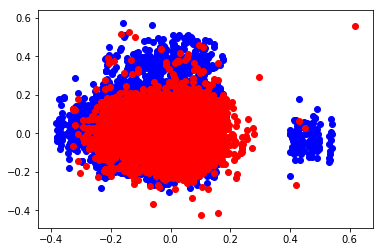

In [17]:
plot_PCA(y=outliers_forest)

**Comment**: IsolationForest method detects well the real outliers (~80% of precision). However, it gives a huge number of false-positive outliers (1 real outlier for ~15 detected).

### K-means

In [18]:
from sklearn.cluster import KMeans

In [19]:
kmeans = KMeans(n_clusters=10).fit(fraud)

In [20]:
dist = np.array([np.linalg.norm(x-y) for x,y in zip(fraud.values, kmeans.cluster_centers_[kmeans.labels_])])

In [21]:
percentage_rejected = 99
hirange = np.percentile(dist, percentage_rejected)
outliers_kmeans = np.zeros(len(dist))
outliers_kmeans[dist>hirange] = 1

In [22]:
print_result_method(outliers_kmeans, name_method="Kmeans")

The Kmeans method give the following results:
	 Number of real outliers: 492
	 Number of outliers detected: 2849
	 Number of real outliers detected: 371
	 Percentage of real outliers detected: 0.75
	 Accuracy of the detection: 5.79


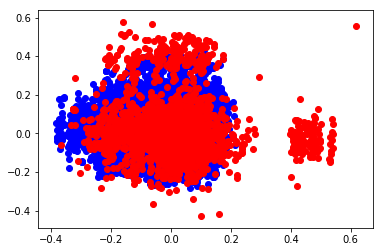

In [23]:
plot_PCA(y=outliers_kmeans)

**Comment:** The Kmeans method gives a better result. It gives approximatively the same precision of real outliers detection and handles really well the false-positive rate in comparison with the precedent method (1 real outlier for ~5 detected). 

### LocalOutlierFactor

In [24]:
model = LocalOutlierFactor(n_neighbors=20, algorithm='auto', n_jobs=-1)

In [25]:
localoutliers = model.fit_predict(fraud)

C:\Users\Sajee\Anaconda3\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [26]:
outliers_local = (localoutliers==-1)

In [27]:
print_result_method(outliers_local, name_method="LocalOutlierFactor")

The LocalOutlierFactor method give the following results:
	 Number of real outliers: 492
	 Number of outliers detected: 28481
	 Number of real outliers detected: 371
	 Percentage of real outliers detected: 0.75
	 Accuracy of the detection: 57.89


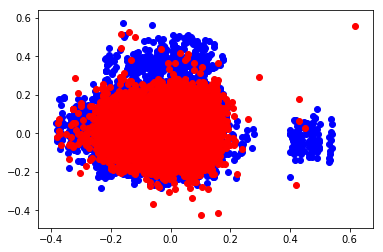

In [28]:
plot_PCA(y=outliers_local)

**Comment:** This method is not suitable for our problem. Indeed, the method detects too much outliers than it has really (1 detected for ~57 found).

### OneClassSVM

In [149]:
model = OneClassSVM(kernel='linear')
oneclasssvm = model.fit(fraud)

In [150]:
temp_oneclasssvm = oneclasssvm.predict(fraud)

In [151]:
np.unique(temp_oneclasssvm)

array([-1,  1], dtype=int64)

In [152]:
outliers_oneclasssvm = (temp_oneclasssvm==-1)

In [153]:
print_result_method(outliers_oneclasssvm, name_method="OneClassSVM")

The OneClassSVM method give the following results:
	 Number of real outliers: 492
	 Number of outliers detected: 142403
	 Number of real outliers detected: 371
	 Percentage of real outliers detected: 0.75
	 Accuracy of the detection: 289.44


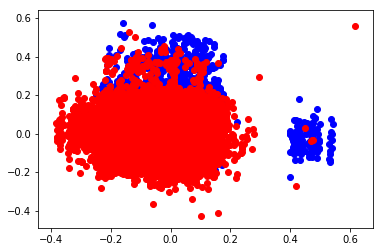

In [154]:
plot_PCA(y=outliers_oneclasssvm)

In [34]:
model = OneClassSVM()  #kernel='linear'
oneclasssvm = model.fit(fraud)

C:\Users\Sajee\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [36]:
temp_oneclasssvm = oneclasssvm.predict(fraud)

In [58]:
np.unique(temp_oneclasssvm)

array([-1,  1], dtype=int64)

In [100]:
outliers_oneclasssvm = (temp_oneclasssvm==-1)

In [101]:
print_result_method(outliers_oneclasssvm, name_method="OneClassSVM")

The OneClassSVM method give the following results:
	 Number of real outliers: 492
	 Number of outliers detected: 142405
	 Number of real outliers detected: 371
	 Percentage of real outliers detected: 0.75
	 Accuracy of the detection: 289.44


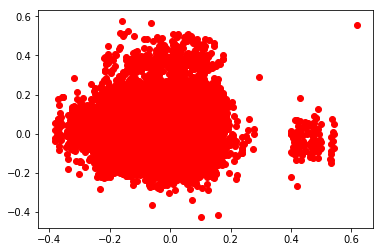

In [107]:
plot_PCA(y=outliers_oneclasssvm)

**Comment:** This result of this method aren't not good and doesn't seem to be appropriate for our problem.
Around $50\%$ of the date are deteted as outliers, so even without the labels, we can easily deduce that this method isn't approrpriate.

## Procédure utilisée pour évaluer la performance d'un algorithme sans utiliser les labels

Afin de vérifier si la pertinence d'un modèle de clustering, on peut évaluer si un ensemble de méthodes de clustering considère que chaque point se situe dans le même cluster, on choisit le cluster élu par la majorité de l'ensemble de méthodes de clustering comme étant le "label". De plus, on pourrait ajouter un expert métier dans le processus afin de s'assurer de la pertience des résultats obtenus.

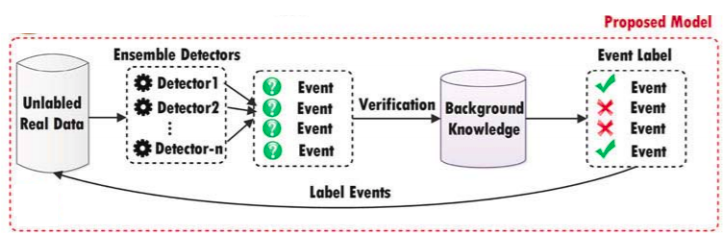

**Référence: Event labeling combining ensemble detectors and background knowledge (June 2014)**
(Article écrit par Hadi Fanaee-T et Joao Gama)

In [134]:
def detection_outliers_combinaison(list_outliers):
    outliers_array = np.array(list_outliers)
    return np.mean(outliers_array, axis=0)>0.5

In [143]:
final_outliers = detection_outliers_combinaison([outliers_forest, outliers_kmeans, outliers_local])

In [144]:
np.sum(final_outliers)

4244

In [145]:
print_result_method(final_outliers, name_method="Combinaison")

The Combinaison method give the following results:
	 Number of real outliers: 492
	 Number of outliers detected: 4244
	 Number of real outliers detected: 371
	 Percentage of real outliers detected: 0.75
	 Accuracy of the detection: 8.63


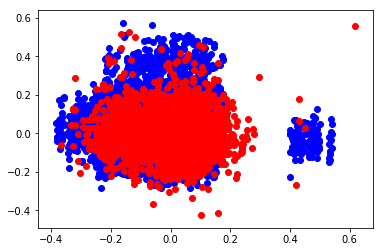

In [146]:
plot_PCA(y=final_outliers)

**Comment:** The combination of all Clustering methods gives the same percentage of real outliers.

In [147]:
final_outliers = detection_outliers_combinaison([outliers_kmeans, outliers_forest])
print_result_method(final_outliers, name_method="Combinaison")

The Combinaison method give the following results:
	 Number of real outliers: 492
	 Number of outliers detected: 2392
	 Number of real outliers detected: 371
	 Percentage of real outliers detected: 0.75
	 Accuracy of the detection: 4.86


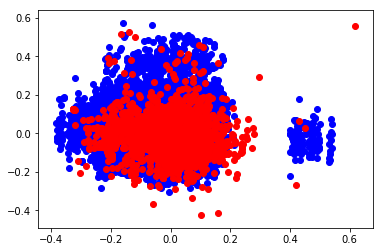

In [148]:
plot_PCA(y=final_outliers)

**Comment:** Using the labels, we can find which Clustering methods are relevant for our problem. Then, without labels, we are able to get good clusters when we will get new data (predictions). Here, we have a better accuracy of the detection (False-Positive Rate) without the LocalOutlierFactor method (even better than a single method).